# Homework: Gaussian Quadrature Integration

###### GH: Gauss-Hermite; GL: Gauss-Legendre; GLa: Gauss-Laguerre

For all the problems, you may obtain $\{\omega_i, \xi_i \}$ directly from Julia's `FastGaussQuadrature` packages. For instance, `xi, wi = gausslegendre(20)` would give $\{\omega_i, \xi_i \}$, $i=1,\ldots,20$, from the Gauss-Legendre rule.

## This problem asks you to adopt the Gauss-Hermite rule to an infinite integral where the weight function does not match.  The integration problem is:
  $$\begin{aligned}
   I = \int_{-\infty}^\infty g(x) d x =  \int_{-\infty}^\infty \exp\left(-\frac{1}{3}x^2\right)\sqrt{1+x^2} dx.
  \end{aligned}$$ 
 

- ##### Let's do this without using changes of variables. 
  - Transform $g(x)$ to $e^{-x^2}f(x)$ so that the Gauss-Hermite rule could be applied. Write down the re-formulated integration problem explicitly and write down $f(x)$ explicitly.
  - Write Julia code to integrate the function numerically.

---
# Answer 1
We can tranform $g(x)$ to $e^{-x^2}f(x)$ by adding terms, which can be illustrated by the following:

$$\begin{aligned}
   \int_{-\infty}^\infty g(x) d x =  \int_{-\infty}^\infty \exp\left(-\frac{1}{3}x^2\right)\sqrt{1+x^2} dx
    = \int_{-\infty}^\infty \exp\left(-x^2\right)\underbrace{\exp\left(\frac{2}{3}x^2\right)\sqrt{1+x^2}}_{f(x)} dx
  \end{aligned}$$

After transforming, below we use Gauss-Hermite rule to compute the integral

In [3]:
using FastGaussQuadrature

# Define the function f(x) as identified above
f(x) = exp((2/3)*x^2) * sqrt(1+x^2)

# set arbitrary node number n and compute the integral with GM rule
n = 100
x, w = gausshermite(n)
integral = sum(w .* f.(x))

println("The approximated integral value of g(x) is: ", integral)


The approximated integral value is: 4.563813002879851


---

## Write a Julia function with the following specifications.
  - It calculates $E[g(y)]$ for any arbitrary $g(y)$ where $y \sim N(\mu, \sigma^2)$.
  - User's inputs include $g(y)$, $\mu$, $\sigma^2$, and $n$.
  - You may obtain $\{\omega_i, \xi_i\}$ directly from Julia's package.
  - If $g(y) = 1 + 3y + y^2$, $y \sim N(1,2)$, and $n=30$, the interface could be like `myInteg(1 + 3y + y^2, mean=1, variance=2, n=30)`, or, `myInteg(g, mean=1, variance=2, n=30)`.
  - Hint: You may define the probability density function of $y$ using the `Distributions` package and then `pdf(Normal(mean, std.dev.),x)`.

---
# Answer 2
By the definition of expectation, we know that $E[g(y)]$ can be written as:

\begin{aligned}
E[g(y)] &= \int_{-\infty}^\infty g(y) f_Y(y) dy \\
    & = \int_{-\infty}^\infty g(y) \frac{1}{\sqrt{2\pi}\sigma} \exp\left( -\frac{1}{2}\left(\frac{y-\mu}{\sigma}\right)^2 \right)dy &&\\
    & = \int_{-\infty}^\infty g(\sqrt{2}\sigma t + \mu) \frac{1}{\sqrt{2\pi}\sigma} \exp(-t^2)\sqrt{2}\sigma dt && (\text{let } y = \sqrt{2}\sigma t + \mu)\\
    & = \int_{-\infty}^\infty  \exp(-t^2) \underbrace{\frac{1}{\sqrt{\pi}}g(\sqrt{2}\sigma t +\mu)}_{f(t)} dt && (\text{rearrange terms})
\end{aligned}


In [10]:
using FastGaussQuadrature, Distributions

# define myInteg function
function myInteg(g, mean, variance, n)

    # compute standard deviation and define f(t) with g(x)
    σ = sqrt(variance)
    f(x) = g(sqrt(2)*σ*x + mean)/sqrt(π)
    
    # compute the integral with GM rule
    x, w = gausshermite(n)
    integral = sum(w .* f.(x))
    
    return integral

end

# choose an arbitrary g(y) and parameters μ, σ^2 as an example
g(y) = 1 + 3y + y^2
μ = 1
σ = sqrt(2)

# use self-defined function applying GM rule to compute the integral
integral = myInteg(g, μ, σ^2, 30)
println("The approximated integral value of E[g(y)] is: ", integral)


The approximated integral value of E[g(y)] is: 6.999999999999998


---

## It is generally true that proper integrals (i.e., with finite domains) are numerically easier to deal with. But what if a problem is naturally a GH type with an infinite domain and we transform it to a GL problem with a finite domain? Is the GL rule better in this scenario? Let's find out the answer. Consider the following integration problem which is often encountered in econometric analysis. 

$$\begin{aligned}
      I = \int_{-\infty}^\infty \Phi\left(\frac{x-a}{b}\right)\phi(x) dx,
\end{aligned}$$

where $X\sim N(0,1)$ is a standard normal random variable, $\phi(z)$ is the density function (PDF) of a random variable $z$, and $\Phi(z)$ is the CDF of $z$.
   - ##### Write a Julia function that uses the GH rule to approximate the integral. The program should be a function of $a$ and $b$.
   - ##### Transform this problem to the GL type. What is the transformation rule and what is the Jacobian? Type the equations and show your work.
   - ##### Write a Julia function that uses the GL rule to approximate the integral. The program should be a function of $a$ and $b$.
   - ##### Suppose the required precision is 6 digits after the decimal. Compare the performances of these functions. Which one converges more quickly (smaller $n$)? You may pick values of $a$ and $b$ to do the comparison. You may draw graphs to compare the results.
   - ##### Based on your results, is the GL rule always the most efficient?

---
# Answer 3

1. Write a Julia function that uses the GH rule to approximate the integral. The program should be a function of $a$ and $b$.

    Note that
    $$
        \phi(x) = \frac{1}{\sqrt{2\pi}}\exp\left(-\frac{x^2}{2}\right)
    $$
    the given integral can be transformed into 
    $$
        I = \int_{-\infty}^\infty \Phi\left(\frac{x-a}{b}\right)\phi(x) dx = \int_{-\infty}^\infty \exp(-x^2) \underbrace{\frac{1}{\sqrt{2\pi}}\Phi\left(\frac{x-a}{b}\right)\exp(\frac{x^2}{2})}_{f(x)} dx
    $$

In [33]:
using FastGaussQuadrature, Distributions

# define GHintg function
function GHInteg(a, b, n = 30)
    
    # get Gauss-Hermite weight and define f(x)
    x, w = gausshermite(n)
    f(x) = (1/sqrt(2π)) * cdf(Normal(0,1),(x-a)/b) * exp(x^2/2)
    
    # compute the integral with GM rule
    integral = sum(w .* f.(x))
    
    return integral

end

# choose arbitrary parameters a and b to integrate
a = 0.5
b = 2
GHInteg(a, b)


0.4115316368790588

2. Transform this problem to the GL type. What is the transformation rule and what is the Jacobian? Type the equations and show your work.

    By letting $x = \frac{t}{1-t^2}$, we have the equation transformed into:

    $$\begin{aligned}
    \int^\infty_{-\infty} \Phi(\frac{x-a}{b})\phi(x)\, \text{d}x
    &= \int_{-\infty}^\infty \Phi\left(\frac{x-a}{b}\right)\frac{1}{\sqrt{2\pi}}\exp(-\frac{x^2}{2}) dx \\
    &= \int^1_{-1} \underbrace{\frac{1}{\sqrt{2\pi}} \Phi(\frac{\frac{t}{1-t^2}-a}{b})\exp\left( -\frac{\left(\frac{t}{1-t^2}\right)^2}{2} \right) \overbrace{\frac{t^2+1}{(t^2-1)^2}}^{\text{Jacobian}}}_{f(t)}\, \text{d}t
    \end{aligned}$$

3. Write a Julia function that uses the GL rule to approximate the integral. The program should be a function of $a$ and $b$.

In [34]:

using FastGaussQuadrature, Distributions

# define GHintg function
function GLInteg(a, b, n = 30)
    
    # get Gauss-Legendre weight and define g(x) and f(x)
    x, w = gausslegendre(n)
    g(x) = x/(1-x^2)
    f(x) = (1/sqrt(2π)) * cdf(Normal(0,1), (g(x)-a)/b) * exp(-g(x)^2/2) * g(x)
    
    # compute the integral with GL rule
    integral = sum(w .* f.(x))
    
    return integral

end

# choose arbitrary parameters a and b to integrate
a = 0.5
b = 2
GLInteg(a, b)


0.03508775633903742

4. Suppose the required precision is 6 digits after the decimal. Compare the performances of these functions. Which one converges more quickly (smaller $n$)? You may pick values of $a$ and $b$ to do the comparison. You may draw graphs to compare the results.

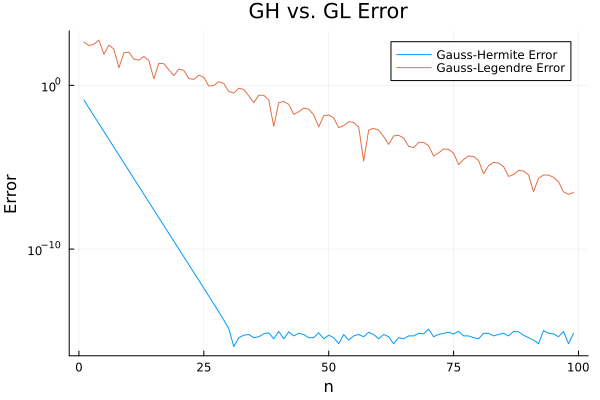

In [59]:
using FastGaussQuadrature, Distributions, Plots

# Define plotErrors for compare the error as n increases
function plotErrors(a, b, max_n)

    # choose an large enough n as approximated real integral value
    true_value_gh = GHInteg(a, b, 100)
    true_value_gl = GLInteg(a, b, 100)
    
    # list for storing error
    errors_gh = []
    errors_gl = []
    ns = 1:max_n
    
    for n in ns
        error_gh = abs(GHInteg(a, b, n) - true_value_gh)
        error_gl = abs(GLInteg(a, b, n) - true_value_gl)
        push!(errors_gh, error_gh)
        push!(errors_gl, error_gl)
    end
    
    # draw the error line
    plot(ns, errors_gh, label="Gauss-Hermite Error", title="GH vs. GL Error", xlabel="n", ylabel="Error", yscale=:log10)
    plot!(ns, errors_gl, label="Gauss-Legendre Error", yscale=:log10)
    
end

# choose arbitrary parameters a and b to integrate
a = 0.5
b = 2
plotErrors(a, b, 99)  # plot error


5. Based on your results, is the GL rule always the most efficient?

    No. In this case, in order to apply the GL rule, we need to transform the original integral, which makes the estimation less efficient
---

## This problem asks you to consider an integration problem where it can be transformed to different types to use different Gaussian quadrature rules. Which one is the best? The integration problem is:

 $$\begin{aligned}
 \int_{a}^\infty \exp\left(-\frac{1}{100}x^2\right)(1+x^2) dx,
 \end{aligned}$$

where $a$ is finite but not necessarily 0. This problem has some characteristics of the GLa and GH types: It has an exponential function, and by mapping $a$ to $-1$, $0$ or $-\infty$ via change of variables, the domain would be of the GL, GLa and GH types, respectively. You are asked to perform the approximation using rules of each of the types and compare the performance. In the code, make $a$ a parameter that we can assign a value to it.

 - ##### Write Julia code that uses the GL rule to approximate the integral. 
 - ##### Write Julia code that uses the GLa rule to approximate the integral. 
 - ##### Write Julia code that uses the GH rule to approximate the integral. 
 - ##### Suppose the required precision is 6 digits after the decimal. Compare the performances of these functions; drawing a graph will be useful. You may pick a value for $a$ in the comparison. 
 - ##### According to your result above, which rule converges more quickly (smaller $n$)? What is the intuition behind the result?

---
# Answer 4

1. Write Julia code that uses the GL rule to approximate the integral. 

    Let $x(t) = a + \frac{1+t}{1-t}$, we have
    $$
        \int_{a}^\infty \exp\left(-\frac{1}{100}x^2\right)(1+x^2) dx
        = \int_{-1}^1 \underbrace{\exp\left(-\frac{1}{100}[x(t)]^2\right)(1+[x(t)]^2)}_{f(t)} \overbrace{\frac{2}{(t-1)^2}}^{\text{Jacobian}} dt
    $$

In [36]:
# define GHintg function
function GLInteg(a, b, n = 30)
    
    # get Gauss-Legendre weight and define g(x) and f(x)
    x, w = gausslegendre(n)
    g(x) = a + (1+x)/(1-x)
    f(x) = exp(-1/100 * g(x)^2) * (1+(g(x))^2) * (2/((x-1)^2))
    
    # compute the integral with GL rule
    integral = sum(w .* f.(x))
    
    return integral

end


# choose arbitrary parameters a and b to integrate
a = 0.5
b = 2
GLInteg(a, b)


451.00574016032874

2. Write Julia code that uses the GLa rule to approximate the integral. 

    Consider the following transformation $t(k) = \frac{k-1}{k+1}$, then
    $$
        \begin{aligned}
        \int_{-1}^1 \exp\left(-\frac{1}{100}[x(t)]^2\right)(1+[x(t)]^2) \frac{2}{(t-1)^2} dt
        &= \int_{0}^\infty \exp\left(-\frac{1}{100}[x(t(k))]^2\right)(1+[x(t(k))]^2) \overbrace{\frac{-2}{(t(k)+1)^2}}^{\text{original Jacobian}} \overbrace{\frac{2}{(k+1)^2}}^{\text{new Jacobian}} dk \\
        &= \int_{0}^\infty \exp(-k) \underbrace{\exp(k) \exp\left(-\frac{1}{100}[x(t(k))]^2\right)(1+[x(t(k))]^2)\overbrace{\frac{-2}{(t(k)+1)^2}}^{\text{original Jacobian}} \overbrace{\frac{2}{(k+1)^2}}^{\text{new Jacobian}}}_{f(t)}  dk
        
        \end{aligned}
    $$

In [54]:
# define GLaintg function
function GLaInteg(a, b, n = 30)
    
    # get Gauss-Legendre weight and define g(x), h(x) and f(x)
    x, w = gausslaguerre(n)

    g(x) = a + (1+x)/(1-x)
    h(x) = (x-1)/(x+1)
    f(x) = exp(x) * exp(-1/100 * h(g(x))^2) * (1+(h(g(x)))^2) * (-2/((h(x)+1))) * (2/(x+1)^2)
    
    # compute the integral with GLa rule
    integral = sum(w .* f.(x))
    
    return integral

end

# choose arbitrary parameters a and b to integrate
a = 0.5
b = 2
GLaInteg(a, b)

-25.241283383622807

3. Write Julia code that uses the GH rule to approximate the integral. 

In [58]:
# Define GHInteg function
function GHInteg(a, n=30)
    
    # get Gauss-Hermit weight and define g(x) and f(x)
    x, w = gausshermite(n)
    
    g(x) = a + (x+1)/(x-1)
    f(x) = exp(g(x)^2 * 99/100) * (1+ g(x)^2) * -2/(x-1)^2
    
    # compute the integral with GH rule
    integral = sum(w .* f.(x))
    
    return integral

end

# choose arbitrary parameters a and b to integrate
a = 0.5
b = 2
GHInteg(a, b)

-9.786554030535776e14

4. Suppose the required precision is 6 digits after the decimal. Compare the performances of these functions; drawing a graph will be useful. You may pick a value for $a$ in the comparison. 

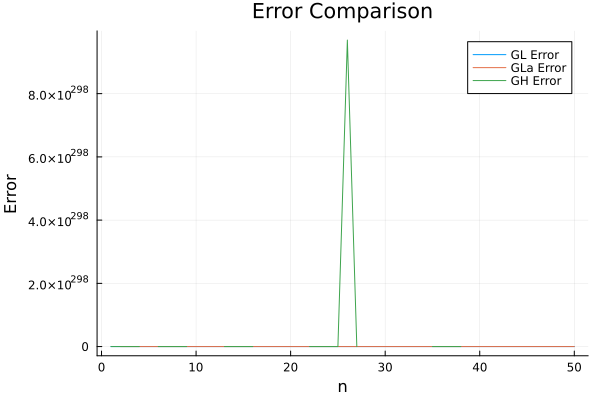

In [61]:
using FastGaussQuadrature, Plots

# Define plotErrors for compare the error as n increases
function compareMethods(a, b, max_n)

    # use n = 1000 as approximated real value
    ref_value = GLInteg(a, b, 1000)

    # store the error in list
    ns = 1:max_n
    gl_errors = []
    gla_errors = []
    gh_errors = []
    
    for n in ns
        gl_result = GLInteg(a, b, n)
        gla_result = GLaInteg(a, b, n)
        gh_result = GHInteg(a, n)
        
        # compute the error
        push!(gl_errors, abs(gl_result - ref_value))
        push!(gla_errors, abs(gla_result - ref_value))
        push!(gh_errors, abs(gh_result - ref_value))

    end
    
    # graph the error lines
    plot(ns, gl_errors, label="GL Error", title="Error Comparison", xlabel="n", ylabel="Error", legend=:topright)
    plot!(ns, gla_errors, label="GLa Error")
    plot!(ns, gh_errors, label="GH Error")

end

# choose arbitrary parameters a and b, then graph the error lines
a = 1
b = 2
compareMethods(a, b, 50)


5. According to your result above, which rule converges more quickly (smaller $n$)? What is the intuition behind the result?

    The three rules seem to be not different in convergence that much, which might due to my previous calculation mistake on the indefinite integral.

---